# Travel Aggregator Analysis

## Introduction

### Overview

This notebook is designed to perform an in-depth analysis of the travel data provided by **MyNextBooking**, an Indian start-up aiming to streamline travel bookings by aggregating prices across major platforms like Yatra, MakeMyTrip (MMT), and Goibibo. The goal of this analysis is to extract actionable insights from historical booking and session data to better understand customer behavior, booking trends, and platform performance.

### Objectives

* Address specific business questions related to bookings, sessions, and customer behavior.
* Provide detailed visualizations and metrics to uncover patterns and trends.
* Deliver actionable insights that can help optimize the platform and improve customer experience.

### Key Questions

This notebook aims to answer the following questions:

1. How many distinct bookings, sessions, and searches are present in the data?
2. How many sessions have more than one booking?
3. Which days of the week see the highest number of bookings, and what is their distribution?
4. What is the total number of bookings and the Gross Booking Value (GBV) for each service name?
5. For customers with multiple bookings, which is the most frequently booked route (from city to city)?
6. Which are the top 3 departure cities with the highest advance bookings (minimum 5 departures)?
7. What is the correlation between numerical columns, and which pair of columns have the highest correlation?
8. For each service name, what is the most commonly used device type for bookings?
9. What are the quarterly trends for bookings by device type?
What are the trends in the overall booking-to-search ratio (oBSR) by:
    * Month of the year
    * Day of the week
    * All available dates (time series plot)

### Datasets

* `Bookings.csv`: Contains detailed information about individual bookings, including customer details, booking time, route information, service name, device type, and Gross Booking Value (GBV).
* `Sessions.csv`: Contains session-level data, including session identifiers, searches performed, session start times, and bookings associated with each session.

### Loading Libraries

In [2]:
import numpy as np # array numerical operations
import pandas as pd # data analysis and manipulation
import matplotlib.pyplot as plt # data visualization
import seaborn as sns

from typing import List, Dict # use type hints 

### Loading the data

In [3]:
# import bookings 
bookings = pd.read_csv('../Data/Bookings.csv')

In [4]:
# preview the data 
bookings.head()

,customer_id,booking_id,from_city,from_country,to_city,to_country,booking_time,device_type_used,INR_Amount,service_name,no_of_passengers,days_to_departure,distance_km
0,customer_259,booking_82,Gurgaon,India,Ahmedabad,India,2020-02-05T16:12:08Z,Desktop,2565.28,MMT,1.0,10.0,747.8
1,customer_303,booking_156,Delhi,India,Brussels,Belgium,2018-11-21T08:21:47Z,Android,23120.00,YATRA,1.0,1.0,6701.5
2,customer_203,booking_99,Devanhalli,India,Frankfurt am Main,Germany,2019-12-16T22:54:58Z,Android,25717.60,YATRA,1.0,32.0,7712.0
3,customer_211,booking_319,Gurgaon,India,Frankfurt am Main,Germany,2021-10-29T12:25:38Z,Desktop,135969.60,GOIBIBO,2.0,69.0,6112.5
4,customer_287,booking_222,Gurgaon,India,Roissy-en-France,France,2020-08-11T16:09:10Z,Android,31791.20,GOIBIBO,1.0,3.0,6570.4


In [5]:
# brief description: Bookings 
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        339 non-null    object 
 1   booking_id         339 non-null    object 
 2   from_city          339 non-null    object 
 3   from_country       339 non-null    object 
 4   to_city            339 non-null    object 
 5   to_country         339 non-null    object 
 6   booking_time       339 non-null    object 
 7   device_type_used   339 non-null    object 
 8   INR_Amount         339 non-null    float64
 9   service_name       339 non-null    object 
 10  no_of_passengers   339 non-null    float64
 11  days_to_departure  339 non-null    float64
 12  distance_km        339 non-null    float64
dtypes: float64(4), object(9)
memory usage: 34.6+ KB


In [6]:
# import sessions
sessions = pd.read_csv('../Data/Sessions.csv')

In [7]:
# preview the data 
sessions.head()

,session_id,search_id,search_time,session_starting_time,booking_id
0,session_322,search_784,2020-01-21T21:35:38.910Z,2020-01-21T21:10:12Z,NaN
1,session_322,search_776,2020-01-21T21:37:37.697Z,2020-01-21T21:10:12Z,NaN
2,session_322,search_623,2020-01-21T21:36:11.392Z,2020-01-21T21:10:12Z,NaN
3,session_322,search_270,2020-01-21T21:16:07.685Z,2020-01-21T21:10:12Z,NaN
4,session_322,search_905,2020-01-21T21:34:55.673Z,2020-01-21T21:10:12Z,NaN


In [8]:
# brief description: Sessions
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1497 entries, 0 to 1496
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   session_id             1497 non-null   object
 1   search_id              1497 non-null   object
 2   search_time            1497 non-null   object
 3   session_starting_time  1497 non-null   object
 4   booking_id             366 non-null    object
dtypes: object(5)
memory usage: 58.6+ KB


## Data Processing

### checking for missing values

In [9]:
def missing_values(data) -> pd.DataFrame:
    """
    checking for missing values in a pandas DataFrame
    
    parameters:
        data pd.DataFrame : Pandas dataframe to check for missing values

    returns:
        missing_df pd.DataFrame: pandas dataframe of columns and their count and percentage of missing values
    """
    # check if dataframe 
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input must be a Pandas DataFrame")
    # check if any missing value
    if not data.isnull().values.any():
        return "The DataFrame has no missing values"
    else:
        missing = data.isnull().sum().sort_values(ascending=False)

        missing_per = np.round(((data.isnull().sum() / len(data)).sort_values(ascending=False)), 2)

        missing_df = pd.DataFrame({
            'column' : missing.index,
            'count': missing.values,
            '%': missing_per.values
        })

        # remove values where count is 0: No mising values
        missing_df = missing_df[missing_df['count'] > 0]

        return missing_df

In [10]:
# missing values: Bookings 
missing_values(bookings)

'The DataFrame has no missing values'

In [11]:
# missing values: Sessions
missing_values(sessions)

,column,count,%
0,booking_id,1131,0.76


* Column `booking_id` has 1131 missng values, which accounts for about `76%` of the total data.

In [12]:
# count of unique entries
sessions['booking_id'].nunique()

338

* `338` unique entries out of `366` total entries available.

In [13]:
# count of unique entries: bookings
bookings['booking_id'].nunique()

339

* All entries of the same column in bookings data are unique.

### Check data types

In [14]:
# data types: sessions
sessions.dtypes

session_id               object
search_id                object
search_time              object
session_starting_time    object
booking_id               object
dtype: object

In [15]:
# data types: bookings 
bookings.dtypes

customer_id           object
booking_id            object
from_city             object
from_country          object
to_city               object
to_country            object
booking_time          object
device_type_used      object
INR_Amount           float64
service_name          object
no_of_passengers     float64
days_to_departure    float64
distance_km          float64
dtype: object

* In both datasets, the columns with date data is treated as object and not date-time.

### Convert Timestamps

In [16]:
def convert_to_datetime(data: pd.DataFrame, column: str, date_format: str) -> pd.DataFrame:
    """
    Convert a specifed column in a DataFrame from object to datetime

    parameters: 
        * data(pd.DataFrame): The input DataFrame
        * column (str): Name of the column to be converted to datetime format
        * date_format (str): The date format to use for conversion

    returns 
        pd.DataFrame: DataFrame with the specified column converted to datetime 
    """
    # check if input is DataFrame 
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    # check if column exists in DataFrame 
    if column not in data.columns:
        raise ValueError(f"Column {column} does not exist in the DataFrame")
    
    # attempt to covert column to datetime
    try:
        data[column] = pd.to_datetime(data[column], format=date_format, errors='coerce')
    except Exception as e:
        raise ValueError(f"Error in converting column '{column}' to datetime: {e}")
    
    return data

In [17]:
# convert booking_time: bookings
bookings = convert_to_datetime(bookings, "booking_time", "%Y-%m-%dT%H:%M:%SZ")
bookings.dtypes

customer_id                  object
booking_id                   object
from_city                    object
from_country                 object
to_city                      object
to_country                   object
booking_time         datetime64[ns]
device_type_used             object
INR_Amount                  float64
service_name                 object
no_of_passengers            float64
days_to_departure           float64
distance_km                 float64
dtype: object

In [18]:
# convert search_time & session_starting_time: sessions
columns = ['search_time', 'session_starting_time']

for col in columns:
    sessions = convert_to_datetime(sessions, col, "%Y-%m-%dT%H:%M:%SZ")

sessions.dtypes

session_id                       object
search_id                        object
search_time              datetime64[ns]
session_starting_time    datetime64[ns]
booking_id                       object
dtype: object

### Merge Datasets

In [19]:
# columns: bookings
bookings.columns

Index(['customer_id', 'booking_id', 'from_city', 'from_country', 'to_city',
       'to_country', 'booking_time', 'device_type_used', 'INR_Amount',
       'service_name', 'no_of_passengers', 'days_to_departure', 'distance_km'],
      dtype='object')

In [20]:
# columns: sessions
sessions.columns

Index(['session_id', 'search_id', 'search_time', 'session_starting_time',
       'booking_id'],
      dtype='object')

* **Left Join**: Want all bookings and the corresponding session data (but don't need sessions without bookings), thus using a left join with `Bookings.csv` as the left table.

In [21]:
def left_join(data1: pd.DataFrame, data2: pd.DataFrame, on: str) -> pd.DataFrame:
    """ 
    Perform a left join between two DataFrames on a specified column.

    parameters:
        * data1 (pd.DataFrame): the first dataframe, on the left
        * data2 (pd.DataFrame): the second dataframe 
        * on (str): The column to join on 

    return:
        pd.DataFrame: The resulting DataFrame after the left join

    raises:
        ValueError: if the columns does not exist in the DataFrame 
    """
    # check if input is DataFrame 
    if not isinstance(data1, pd.DataFrame) or not isinstance(data2, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    # check if the columns exist 
    if on not in data1.columns:
        raise ValueError(f"Column '{on}' not in the first dataframe")
    if on not in data2.columns:
        raise ValueError(f"Column '{on}' not in the second dataframe")
    
    # perform left join
    merged_data = pd.merge(data1, data2, on=on, how='left')

    # drop duplicated entries
    merged_data.drop_duplicates(inplace=True, ignore_index=True)

    return merged_data

In [22]:
# merge bookings and sessions
merged_data = left_join(bookings, sessions, on='booking_id')
# brief description: merged_data
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_id            340 non-null    object        
 1   booking_id             340 non-null    object        
 2   from_city              340 non-null    object        
 3   from_country           340 non-null    object        
 4   to_city                340 non-null    object        
 5   to_country             340 non-null    object        
 6   booking_time           340 non-null    datetime64[ns]
 7   device_type_used       340 non-null    object        
 8   INR_Amount             340 non-null    float64       
 9   service_name           340 non-null    object        
 10  no_of_passengers       340 non-null    float64       
 11  days_to_departure      340 non-null    float64       
 12  distance_km            340 non-null    float64       
 13  sessi

## Analysis Section

### Q1 Count Distinct Bookings, Sessions and Searches

* Use pandas' `nunique()` function to find the unique counts of bookings, sessions and searches.

In [23]:
def unique_counts(data: pd.DataFrame, columns: List[str]) -> Dict[str, int]:
    """
    Retrieve the unique counts for specified columns in a DataFrame.

    parameters:
        data (pd.DataFrame): The input DataFrame 
        columns (List[str]): List of column names to calculate unique counts for.

    returns:
        Dict[str, int]: A dictionary with column names as keys and their unique counts as values

    raise
        ValueError: if column does not exist in the DataFrame
    """
    # check if input is a DataFrame 
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")
    # validate all the columns exist in the DataFrame
    for col in columns:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' does not exist in the DataFrame.")
        
    # calculate the unique counts for each column 
    unique_counts = {col: data[col].nunique() for col in columns}

    return unique_counts

In [24]:
# unique bookings
unique_counts(bookings, ['booking_id'])

{'booking_id': 339}

In [25]:
# unique sessions and searches
unique_counts(sessions, ['session_id', 'search_id'])

{'session_id': 331, 'search_id': 1360}

### Q2 Sessions with Multiple Bookings

* Group by `session_id` and count the number of associated `booking_id`.
* Filter sessions with more than one booking

In [27]:
def group_count_and_filter(data: pd.DataFrame, group_by: List[str], count_column: str, threshold: int) -> pd.Series:
    """ 
    Group a DataFrame by specified columns, count occurrences, and filter rows exceeding a threshold

    Parameters:
        * data (pd.DataFrame): Input DataFrame
        * group_by (List[str]): List of column(s) to group the data by.
        * count_column (str): The column to count occurrences for.
        * threshold (int): The minimum count threshold for filtering

    returns:
        pd.Series: A Series with group counts filtered by the threshold

    raises:
        ValueError: If any grouping columns or count column does not exist in the DataFrame  
    """

    # check if DataFrame 
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input must be a DataFrame")
    
    # validate group by columns
    for col in group_by:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' does not exist in the DataFrame")
        
    # validate count columns
    if count_column not in data.columns:
        raise ValueError(f"Column '{count_column}' does not exist in the DataFrame")
    
    # group by specified columns and count occurrences
    grouped_data = data.groupby(group_by)[count_column].count().sort_values(ascending=False)

    # filter rows where the count exceeds the threshold
    filtered_data = grouped_data[grouped_data > threshold]

    return filtered_data
    

In [28]:
# sessions data
grouped_sessions = group_count_and_filter(sessions, ['session_id'], 'booking_id', 1)

grouped_sessions

session_id
session_76     3
session_134    3
session_237    2
session_124    2
session_171    2
session_298    2
session_38     2
session_231    2
session_132    2
session_205    2
session_94     2
session_68     2
session_164    2
session_162    2
session_29     2
session_290    2
session_5      2
session_50     2
session_51     2
session_154    2
session_122    2
session_137    2
session_190    2
session_32     2
session_323    2
session_102    2
session_324    2
session_325    2
session_90     2
session_327    2
session_196    2
session_179    2
session_27     2
session_80     2
session_181    2
Name: booking_id, dtype: int64

In [29]:
# value counts
grouped_sessions.value_counts()

booking_id
2    33
3     2
Name: count, dtype: int64

In [144]:
# sessions with more than one bookings
len(grouped_sessions)

35

### Q3 Bookings by Day of the Week

* Extract the day of the week from `booking_time`
* count bookings for each day
* Visualize the distribution using a pie chart

In [30]:
def bookings_by_day(data: pd.DataFrame, datetime_column: str) -> Dict[str, int]:
    """ 
    Count bookings by day of the week from a Datetime column.
    
    Parameters:
        data (pd.DataFrame): The input DataFrame
        datetime_column (str): The name of the datetime column to extract the day of the week from.

    Returns:
        Dict[str, int]: A dictionary with days of the weeks as keys and their booking counts as Values

    Raises:
        ValueError: If the column does not exist in the DataFrame or is not in datetime format
    """
    # check if input DataFrame 
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input must be a DataFrame.")
    # check if the datetime columns does exist
    if datetime_column not in data.columns:
        raise ValueError(f"Column '{datetime_column}' does not exist in the DataFrame.")
    # check if the column is in datetime format 
    if not pd.api.types.is_datetime64_any_dtype(data[datetime_column]):
        raise ValueError(f"Column '{datetime_column}' must be in datetime fortmat.")
    
    # Extract the day of the week and count bookings 
    day_counts = data[datetime_column].dt.day_name().value_counts().to_dict()

    return day_counts

In [31]:
# count bookings for each day 
day_booking_counts = bookings_by_day(merged_data, 'booking_time')

day_booking_counts

{'Thursday': 65,
 'Tuesday': 59,
 'Monday': 51,
 'Friday': 51,
 'Saturday': 45,
 'Sunday': 35,
 'Wednesday': 34}

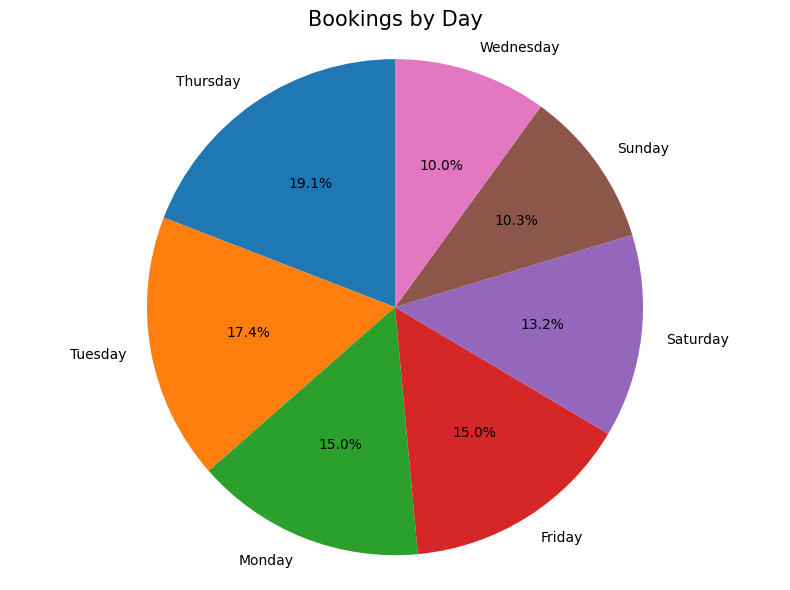

In [32]:
# visualize using a pie chart 
fig, ax = plt.subplots(figsize=(8, 6))

labels = list(day_booking_counts.keys())
sizes = list(day_booking_counts.values())

ax.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90) # plot the chart

ax.axis('equal') # equal aspect ratio: ensure pie is drawn as a circle

ax.set_title("Bookings by Day", fontsize=15) # label the chart

# show the plot
plt.tight_layout()
plt.show()

# save the image
fig.savefig("../assets/images/bookings.png")

### Q4 Total Bookings and Gross Booking Value by service

* Group by `service_name` and calculate:
    * Total Bookings 
    * Total Gross booking value (sum of `INR_Amount`)

In [33]:
def aggregate_bookings(data: pd.DataFrame, group_by: List[str], agg_columns: Dict[str, tuple]) -> pd.DataFrame:
    """ 
    Aggregate booking data by grouping and calcultaing specific metrics
    
    parameters:
        * data (pd.DataFrame): The input DataFrame
        * groupby (List[str]): List of column(s) the group the data by
        * agg_columns(Dict[str, tuple]): A dictionary specifying aggregation operations.
            keys are new column names, and values are tuples of (column_name, operation)
            Example: {'booking_count': ('booking_id', 'count'), 'total_amount': ('INR_Amount', 'sum')}
    
    returns:
        pd.DataFrame: A DataFrame with aggregated metrics for each group

    raises:
        ValueError: If any of the grouping columns or any specified aggregation column does not exist.
    """
    # check if data is dataframe 
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")
    # check if the group by columns exist
    for col in group_by:
        if col not in data.columns:
            raise ValueError(f"Grouping column '{col}' does not exist in the DataFrame")
        
    # check if all aggregation columns exist
    for col, _ in agg_columns.values():
        if col not in data.columns:
            raise ValueError(f"Aggregation column '{col}' does not exist in the DataFrame")
        
    # perform group aggregation 
    aggregated_data = data.groupby(group_by).agg(**agg_columns).reset_index()

    return aggregated_data

In [34]:
# define aggregation metrics
aggregation_metrics = {
    "booking_count": ("booking_id", "count"),
    "total_amount": ("INR_Amount", "sum")
}
gross_book_value = aggregate_bookings(merged_data, ['service_name'], aggregation_metrics)

gross_book_value

,service_name,booking_count,total_amount
0,GOIBIBO,187,5969072.37
1,MMT,48,665669.08
2,YATRA,105,3378702.13


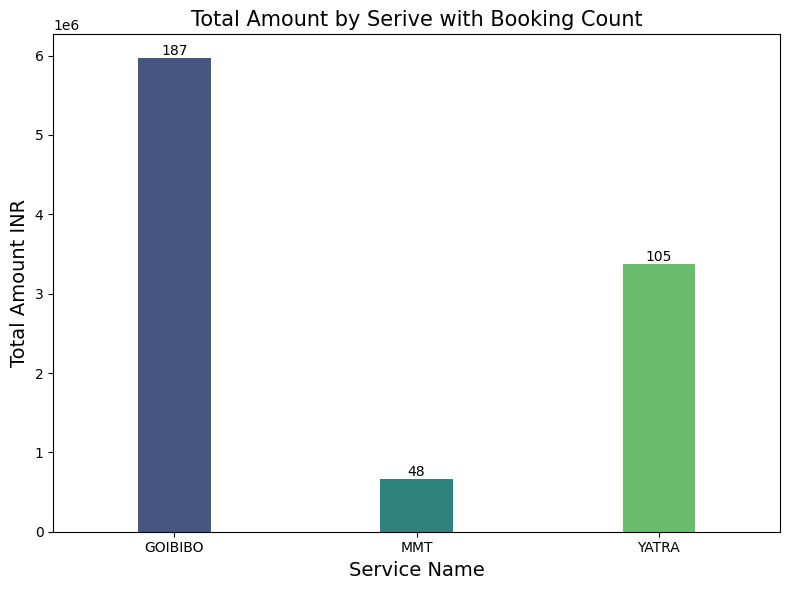

In [35]:
# visualize
fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(x='service_name', y='total_amount', data=gross_book_value, ax=ax, width=0.3, palette='viridis', hue='service_name')

# annotate with booking count on each bar
for i, row in gross_book_value.iterrows():
    ax.text(i, row['total_amount'], f"{row['booking_count']}",
            ha='center', va='bottom', fontsize=10)
    
# label the graph
ax.set_title("Total Amount by Serive with Booking Count", fontsize=15)
ax.set_ylabel("Total Amount INR", fontsize=14)
ax.set_xlabel("Service Name", fontsize=14)

# display the graph 
plt.tight_layout()
plt.show()

# save 
fig.savefig("../assets/images/service_amount_and_count.png")

### Q5 Most Booked Route for Customers with Multiple Bookings

* Filter Customers with more than one booking using `customer_id`.
* Group by `from_city` and `to_city` to find the most common route.

In [36]:
def get_customer_with_multiple_bookings(data: pd.DataFrame, customer_column: str, booking_column:str, threshold: int) -> pd.Index:
    """ 
    Identify customers with more than one booking.
    
    Parameters:
        * data (pd.DataFrame): the input DataFrame
        * customer_column (str): Name of column representing customer IDs
        * booking_column (str): Name of column representing booking IDs
        * threshold (int): threshold to filter the multiple bookings

    returns:
        pd.Index: Index of customers with more than one bookings

    raises:
        ValueError: if the customer_column and booking_column don't exist in the DataFrame
    """
    # check if data is DataFrame
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input must be a DataFrame")
    # check if columns are in DataFrame
    if (customer_column not in data.columns):
        raise ValueError(f"Customer column '{customer_column}' does not exist in the DataFrame")
    elif (booking_column not in data.columns):
        raise ValueError(f"Booking column '{booking_column}' does not exist in the DataFrame")
    
    # group by customers and count their bookings
    customer_booking_counts = data.groupby(customer_column)[booking_column].count()

    # filter customers with more than threshold
    return customer_booking_counts[customer_booking_counts > threshold].index

In [37]:
# customers with more than one bookings
customer_with_multiple_bookings = get_customer_with_multiple_bookings(merged_data, 'customer_id', 'booking_id', 1)

# number of customers with multiple bookings
len(customer_with_multiple_bookings)

27

In [38]:
def get_most_booked_route(data: pd.DataFrame, customer_column: str, from_column: str, to_column: str, booking_column: str, threshold: int) -> pd.Series:
    """ 
    Find the most booked routes for customers with a certain threshold of bookings.
    
    Parameters:
        * data (pd.DataFrame): The input DataFrame.
        * customer_column (str): Name of the column representing customer IDs.
        * from_column (str): Name of the column representing the starting city.
        * to_city (str): Name of the column representing the destination city.
        * booking_column (str): Name of the column representing the booking IDs.
        * threshold (int): threshold to filter the multiple bookings 

    Returns:
        pd.Series: A series with routes as the index and the count of bookings as values

    Raises:
        ValueError: If the columns customer_column, from_column, to_column, booking_column do not exist in the DataFrame
    """
    # check if input is DataFrame 
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input must be DataFrame")
    # validate columns 
    columns = [customer_column, from_column, to_column, booking_column]

    for col in columns:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' does not exist in the DataFrame")
    
    # filter customers with more than threshold bookings
    multi_booking_customers = get_customer_with_multiple_bookings(data, customer_column, booking_column, threshold)

    # filter data for these customers 
    filtered_data = data[data[customer_column].isin(multi_booking_customers)]

    # group by routes and count bookings 
    most_booked_routes = filtered_data.groupby([from_column, to_column]).agg(Bookings_Count = (booking_column, "count")).sort_values(by="Bookings_Count", ascending=False)

    return most_booked_routes

In [148]:
# most booked routes 
most_booked_routes = get_most_booked_route(merged_data, 'customer_id', 'from_city', 'to_city', 'booking_id', 1)

most_booked_routes

Bookings_Count
from_city          to_city                          
Gurgaon            Roissy-en-France                5
                   Lisbon                          3
                   Rāja Sānsi                      3
Durlaga            Bhubaneswar                     2
Bālāpur            Düsseldorf                      2
Devanhalli         Gurgaon                         2
Gurgaon            Bhubaneswar                     2
                   Bagdogra                        2
                   Paris                           2
                   Tiruchi                         2
Delhi              Jammu                           1
Bikaner            Gurgaon                         1
Barelā             Gurgaon                         1
Ahmedabad          Gwalior                         1
Gurgaon            Barelā                          1
Dharamsala         Gurgaon                         1
Delhi              Varanasi                        1
                   Yol                             1
                   Paris                           1
Bhubaneswar        Durlaga                         1
Gurgaon            Birmingham                      1
                   Berlin                          1
                   Hamburg                         1
                   Frankfurt am Main               1
                   Fiumicino                       1
                   Dharamsala                      1
                   Port Blair                      1
                   Patna                           1
                   Mumbai                          1
                   Varanasi                        1
Indore             Mumbai                          1
Jaipur             Agra                            1
Jammu              Dubai                           1
Kochi              London                          1
Kolkata            Gurgaon                         1
Madhyamgram        Frankfurt am Main               1
Mumbai             Chicalim                        1
                   Jaipur                          1
                   Lucknow                         1
Patna              Gurgaon                         1
Pune               Nagpur                          1
Rāja Sānsi         Gurgaon                         1
                   Paris                           1
Surat              Devanhalli                      1
Thiruvananthapuram London                          1
Varanasi           Delhi                           1

In [149]:
# most booked route 
most_booked_routes = most_booked_routes.reset_index()

# find the most booked route
most_booked_route = most_booked_routes.loc[most_booked_routes['Bookings_Count'].idxmax()]

most_booked_route

from_city                  Gurgaon
to_city           Roissy-en-France
Bookings_Count                   5
Name: 0, dtype: object

### Q6 Top 3 Departure Cities for Advanced Bookings

* Filter rows where `days_to_departure` is greater than a threshold.
* Group by `from_city` and count the number of bookings.
* Sort and filter cities with atleast 5 departures.

In [40]:
def top_depature_cities_advanced_bookings(
        data: pd.DataFrame, from_city: str, days_to_depature: str, booking_column: str, 
        advanced_threshold: int, min_depatures: int, top_n: int
) -> pd.DataFrame:
    """ 
    Identify the top depature cities where customers book mostly in advance
    
    Parameters:
        * data (pd.DataFrame): Input DataFrame containing the booking data.
        * from_city (str): Name of the column representing the departure city.
        * days_to_depature (str): Name of the columns representing the days to departure.
        * booking_column (str): Name of the column representing the unique booking IDs.
        * advanced_threshold (int): Threshold of days to depature to consider a booking "in advance".
        * min_depatures (int): Minimum number of departures required to include a city in the analysis
        * top_n (int): Number of top cities to return 

    Returns:
        pd.DataFrame: A DataFrame with the top cities and their advance booking counts 
    """
    # check if input is DataFrame 
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input must be a DataFrame")
    # validate columns
    columns = [from_city, days_to_depature, booking_column]
    for col in columns:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' does not exist in the DataFrame")
    # validate int parameters
    if not isinstance(advanced_threshold, int) or (advanced_threshold < 0):
        raise ValueError(f"{advanced_threshold} must be a positive interger")
    if not isinstance(min_depatures, int) or (min_depatures < 0):
        raise ValueError(f"{min_depatures} must be a positive interger")
    if not isinstance(top_n, int) or (top_n <= 0):
        raise ValueError(f"{top_n} must be a positive interger greater than 0")
    
    # filter rows where bookings are made in advance 
    advanced_bookings = data[data[days_to_depature] > advanced_threshold]

    # Group by departure city and count bookings 
    city_bookings_count = advanced_bookings.groupby(from_city).agg(Booking_Count=(booking_column, "count")).reset_index()

    # filter cities with at least the minimum number of departures 
    filtered_cities = city_bookings_count[city_bookings_count['Booking_Count'] >= min_depatures]

    # sort by booking count in descending order
    top_cities = filtered_cities.sort_values(by='Booking_Count', ascending=False).head(top_n)

    return top_cities.reset_index(drop=True)

In [41]:
# parameters
advanced_threshold = 7 # customer booking 7 days in advance 
min_departures = 5
top_n = 3

top_depature_cities_advanced_bookings(merged_data, 'from_city', 'days_to_departure', 'booking_id', advanced_threshold, min_departures, top_n)

,from_city,Booking_Count
0,Gurgaon,79
1,Mumbai,17
2,Delhi,16


### Q7 Heatmap for Correlations
* Select Numerical columns from the dataset.
* Calculate pairwise correlations using pandas' `corr()` method.
* Visualize the correlations using seaborn's heatmap.
* Identify the pair with the highest correlation.

In [44]:
def numerical_correlation(data: pd.DataFrame, numerical_cols: List[str]) -> pd.DataFrame:
    """ 
    Calculate the correlation matrix for specified numerical columns in a pandas DataFrame

    Parameters:
        * data(pd.DataFrame): Input DataFrame containing the Data.
        * numerical_cols (List[str]): List of column names to calculate correlations for.

    Returns: 
        pd.DataFrame: Correlation Matrix of the specified numerical columns 
    """
    # check if input is DataFrame
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input must be a DataFrame")
    
    # validate numerical cols
    for col in numerical_cols:
        if (col not in data.columns):
            raise ValueError(f"Column '{col}' does not exist in the DataFrame")
        elif not pd.api.types.is_numeric_dtype(data[col]):
            raise TypeError(f"Column '{col}' must be of numeric data type")
    
    # calculate correlation 
    correlation_maxtrix = data[numerical_cols].corr()

    return correlation_maxtrix

In [43]:
# data types 
bookings.dtypes

customer_id                  object
booking_id                   object
from_city                    object
from_country                 object
to_city                      object
to_country                   object
booking_time         datetime64[ns]
device_type_used             object
INR_Amount                  float64
service_name                 object
no_of_passengers            float64
days_to_departure           float64
distance_km                 float64
dtype: object

In [45]:
# select numerical columns 
numerical_cols = ['INR_Amount', 'no_of_passengers', 'days_to_departure', 'distance_km']

In [46]:
# calculate pairwise correlations
correlation_matrix = numerical_correlation(bookings, numerical_cols=numerical_cols)

correlation_matrix

,INR_Amount,no_of_passengers,days_to_departure,distance_km
INR_Amount,1.000000,0.397229,0.284534,0.623565
no_of_passengers,0.397229,1.000000,0.187128,0.001698
days_to_departure,0.284534,0.187128,1.000000,0.216972
distance_km,0.623565,0.001698,0.216972,1.000000


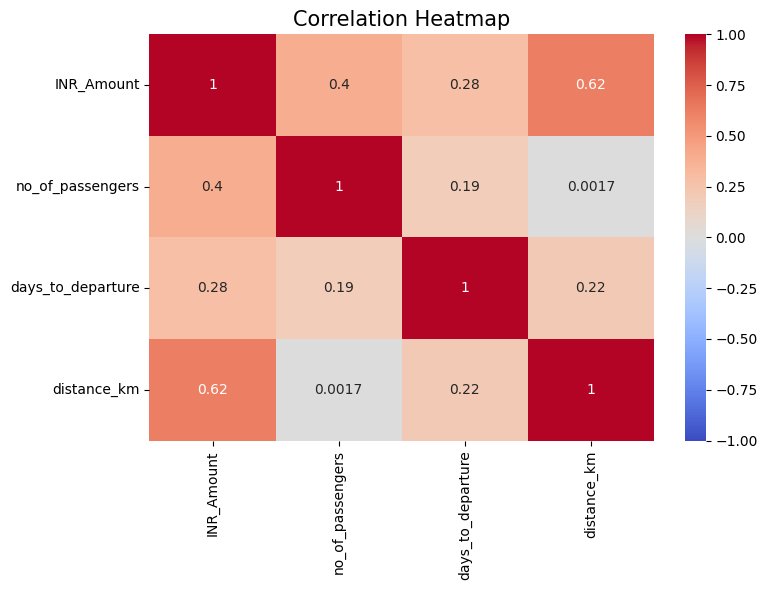

In [55]:
# plotting correlation heatmap
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, ax=ax)

# set title 
ax.set_title("Correlation Heatmap", fontsize=15)

plt.tight_layout()
plt.show()

# save the figure 
fig.savefig("../assets/images/correlation.png")

### Q8 Device Type by Service

* Group by `service_name` and `device_type_used`.
* Count the bookings for each device type.
* Identify the most common device type for each service.

In [63]:
def device_type_by_service(data: pd.DataFrame, service_column: str, device_column: str, booking_column: str) -> pd.DataFrame:
    """ 
    Identify the most common device type used for bookings for each service
    
    Parameters: 
        * data (pd.DataFrame): Input DataFrame containing booking data.
        * service_column (str): Name of column representing the service name.
        * device_column (str): Name of the column representing the device type used.
        * booking_column (str): Name of the column representing the booking IDs.

    Returns:
        pd.DataFrame: A DataFrame with the most common device type for each service and the count of bookings for that device.

    """
    # check if data is DataFrame
    if  not isinstance(data, pd.DataFrame):
        raise TypeError("Input must be a DataFrame")
    # validate the columns 
    columns = [service_column, device_column, booking_column]

    for col in columns:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' does not exist in the DataFrame")
    
    # group by service and device type, count bookings 
    grouped_data = data.groupby([service_column, device_column]).agg(Bookings_Count=(booking_column, "count")).reset_index()

    # find the most common device type for each service
    most_common_device = grouped_data.loc[
        grouped_data.groupby(service_column)['Bookings_Count'].idxmax()
    ].reset_index(drop=True)

    return most_common_device

In [64]:
device_type_by_service(merged_data, 'service_name', 'device_type_used', 'booking_id')

,service_name,device_type_used,Bookings_Count
0,GOIBIBO,IOS,70
1,MMT,Desktop,30
2,YATRA,Desktop,51


### Q9 Quartely Trends by Device Type
* Extract year and quarter from `booking_time`.
* Group by year, quarter, and `device_type_used` to count bookings.
* Plot a time series for each device type across quarters.

In [66]:
def group_bookings_by_time_and_device(data: pd.DataFrame, date_time:str, device_column: str, booking_column: str) -> pd.DataFrame:
    """ 
    Group bookings by year, quarter, and device type, counting the number of bookings
    
    Parameters: 
        * data (pd.DataFrame): Input DataFrame containing booking data.
        * date_time (str): Name of column representing the datetime of bookings.
        * device_column (str): Name of column representing the device type used.
        * booking_column (str): Name of the column representing booking IDs

    Returns: 
        pd.DataFrame: A DataFrame grouped by year, quarter, and device type with booking counts.
    """
    # check if input is a DataFrame
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input must be a DataFrame")
    
    # validate the columns
    columns = [date_time, device_column, booking_column]
    for col in columns:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' does not exist in the DataFrame")
    
    # check if the column is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(data[date_time]):
        raise TypeError(f"Column '{date_time}' must be in datetime format.")
    
    # extract the year and quarter
    data['year'] = data[date_time].dt.year
    data['quarter'] = data[date_time].dt.quarter

    # group by year, quarter, and device column, then count bookings
    grouped_data = data.groupby(['year', 'quarter', device_column]).agg(Bookings_Count=(booking_column, 'count')).reset_index()

    return grouped_data

In [68]:
result = group_bookings_by_time_and_device(merged_data, 'booking_time', 'device_type_used', 'booking_id')

result

,year,quarter,device_type_used,Bookings_Count
0,2018,3,Android,3
1,2018,3,Desktop,6
2,2018,3,MobileWeb,2
3,2018,3,Tablet,1
4,2018,4,Android,3
5,2018,4,Desktop,22
6,2018,4,IOS,4
7,2018,4,MobileWeb,4
8,2018,4,Tablet,1
9,2019,1,Desktop,1


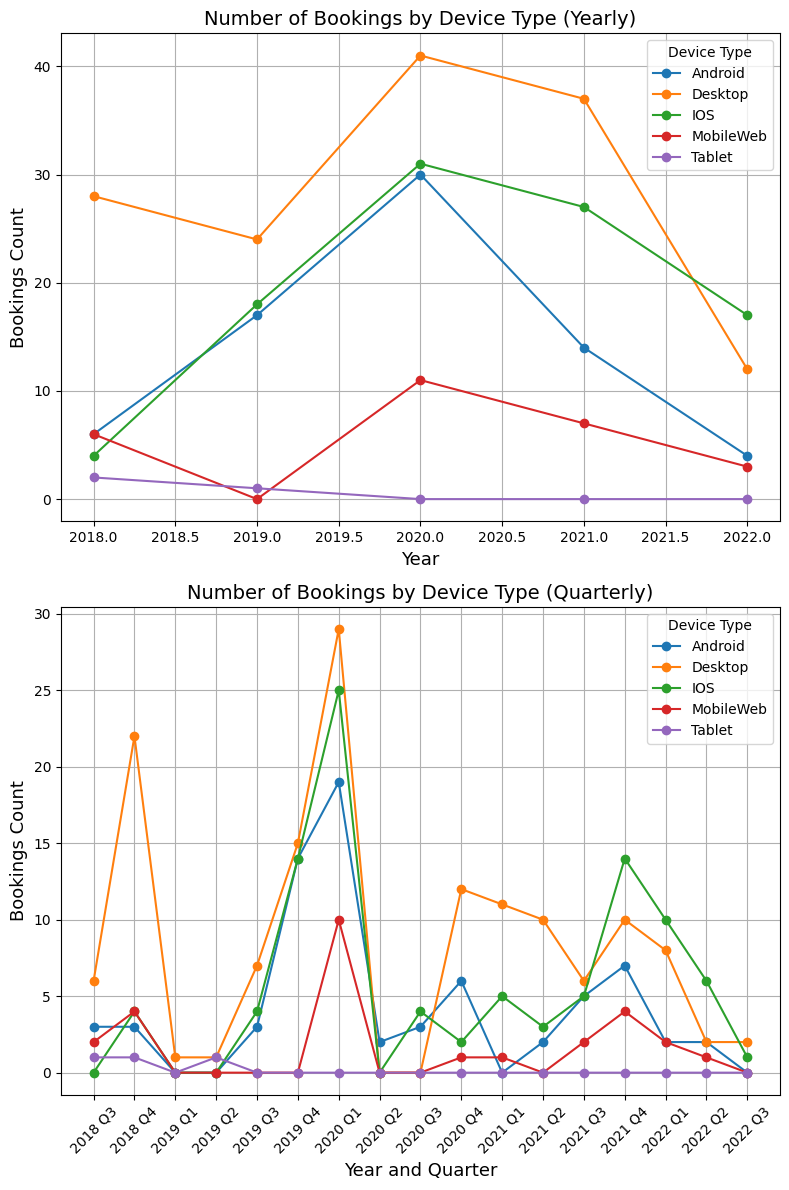

In [84]:
# aggregate the data for yearly plot
yearly_data = result.groupby(['year', 'device_type_used'])['Bookings_Count'].sum().unstack(fill_value=0)

# aggregate the data for quarterly plot
quartely_data = result.groupby(['year', 'quarter','device_type_used'])['Bookings_Count'].sum().unstack(fill_value=0)

# create subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 12), sharex=False) # dont share X axis between suplots

# yearly plot
for device in yearly_data.columns:
    ax[0].plot(yearly_data.index, yearly_data[device], marker='o', label=device)

ax[0].set_title("Number of Bookings by Device Type (Yearly)", fontsize=14)
ax[0].set_xlabel("Year", fontsize=13)
ax[0].set_ylabel("Bookings Count", fontsize=13)
ax[0].legend(title="Device Type", fontsize=10)
ax[0].grid(True)

# quarterly plot
quartely_data.index = [f"{y} Q{q}" for y, q in quartely_data.index]
for device in quartely_data.columns:
    ax[1].plot(quartely_data.index, quartely_data[device], marker='o', label=device)

ax[1].set_title("Number of Bookings by Device Type (Quarterly)", fontsize=14)
ax[1].set_xlabel("Year and Quarter", fontsize=13)
ax[1].set_ylabel("Bookings Count", fontsize=13)
ax[1].legend(title="Device Type", fontsize=10)
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

# adjust layout
plt.tight_layout()
plt.show()

# save the figure 
fig.savefig("../assets/images/time_series.png")

### Q10 oBSR Analysis
* Calculate `oBSR` as bookings divided by searches:
    * For each month: Group by month and compute the ratio.
    * For each day of the week: Group by day and compute the ratio.
* Plot a time series of daily oBSR.

In [97]:
# Calculate oBSR by Month
def calculate_monthly_obsr(data: pd.DataFrame, date_column:str, booking_column:str, searches_column: str) -> pd.DataFrame:
    """ 
    Calculate the overall monthly booking to search ratio
    
    Parameters:
        * data (pd.DataFrame): Input DataFrame containing the booking data
        * date_column (str): Name of the column containing the datetime booking data.
        * booking_column (str): Name of the column representing the booking IDs.
        * searches_column (str): Name of the column representing the search IDs.

    Returns:
        pd.DataFrame: a pandas DataFrame with the overall monthly booking to search ratio
    """
    # check if input is DataFrame 
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")
    # check if columns exist in the DataFrame 
    columns = [date_column, booking_column, searches_column]
    for col in columns:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' does not exist in the DataFrame.")
    # validate the date_column
    if not pd.api.types.is_datetime64_any_dtype(data[date_column]):
        raise TypeError(f"{date_column} must be in datetime format.")
    
    # extract the month column
    data['month'] = data[date_column].dt.month_name()

    # calculate monthly obsr
    monthly_obsr = data.groupby('month').agg(
        Total_Bookings=(booking_column, 'count'),
        Total_Searches=(searches_column, 'count')
    )

    monthly_obsr['oBSR'] = np.round((monthly_obsr['Total_Bookings'] / monthly_obsr['Total_Searches']), 4)

    return monthly_obsr

In [115]:
# calculate monthly oBSR
monthly_obsr = calculate_monthly_obsr(sessions, 'session_starting_time', 'booking_id', 'search_id')

# desired monthly order
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# reindex the order
monthly_obsr = monthly_obsr.reindex(month_order)

monthly_obsr

,Total_Bookings,Total_Searches,oBSR
month,,,
January,27,135,0.2000
February,20,90,0.2222
March,15,71,0.2113
April,6,30,0.2000
May,5,23,0.2174
June,4,14,0.2857
July,6,54,0.1111
August,5,12,0.4167
September,17,44,0.3864


In [130]:
# Calculate oBSR by Month
def calculate_daily_obsr(data: pd.DataFrame, date_column:str, booking_column:str, searches_column: str) -> pd.DataFrame:
    """ 
    Calculate the overall weekly booking to search ratio
    
    Parameters:
        * data (pd.DataFrame): Input DataFrame containing the booking data
        * date_column (str): Name of the column containing the datetime booking data.
        * booking_column (str): Name of the column representing the booking IDs.
        * searches_column (str): Name of the column representing the search IDs.

    Returns:
        pd.DataFrame: a pandas DataFrame with the overall monthly booking to search ratio
    """
    # check if input is DataFrame 
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")
    # check if columns exist in the DataFrame 
    columns = [date_column, booking_column, searches_column]
    for col in columns:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' does not exist in the DataFrame.")
    # validate the date_column
    if not pd.api.types.is_datetime64_any_dtype(data[date_column]):
        raise TypeError(f"{date_column} must be in datetime format.")
    
    # extract the day of the week column
    data['day'] = data[date_column].dt.day_name()

    # calculate weekly obsr
    daily_obsr = data.groupby('day').agg(
        Total_Bookings=(booking_column, 'count'),
        Total_Searches=(searches_column, 'count')
    )

    daily_obsr['oBSR'] = np.round((daily_obsr['Total_Bookings'] / daily_obsr['Total_Searches']), 4)

    return daily_obsr

In [131]:
# calculate daily oBSR
daily_obsr = calculate_daily_obsr(sessions, 'session_starting_time', 'booking_id', 'search_id')

# desired order of days 
day_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

# reindex to reorder the index
daily_obsr = daily_obsr.reindex(day_order)

daily_obsr

,Total_Bookings,Total_Searches,oBSR
day,,,
Sunday,13,63,0.2063
Monday,28,111,0.2523
Tuesday,27,104,0.2596
Wednesday,19,126,0.1508
Thursday,29,97,0.2990
Friday,29,123,0.2358
Saturday,26,115,0.2261


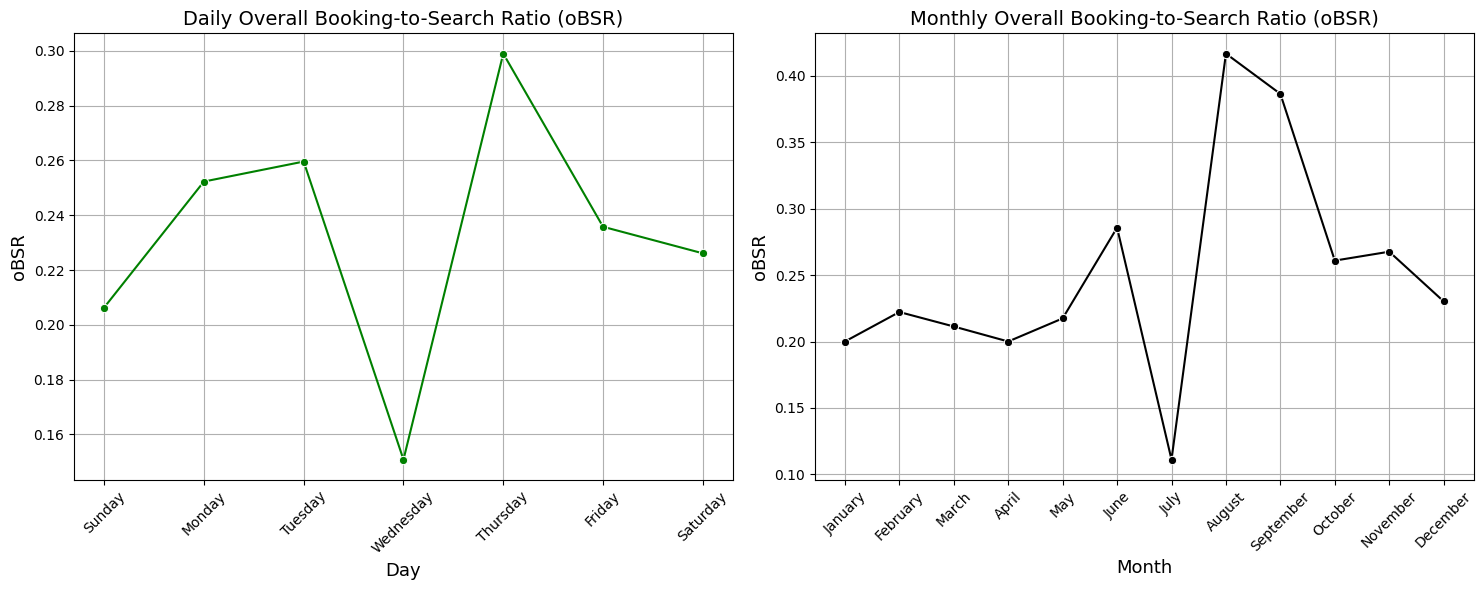

In [140]:
# visualize
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=False)

# daily oBSR
sns.lineplot(x=daily_obsr.index, y=daily_obsr['oBSR'], data=daily_obsr, ax=ax[0], marker='o', color='green')

ax[0].set_title("Daily Overall Booking-to-Search Ratio (oBSR)", fontsize=14)
ax[0].set_ylabel("oBSR", fontsize=13)
ax[0].set_xlabel("Day", fontsize=13)
ax[0].tick_params(axis='x', rotation=45)
ax[0].grid(True)

# monthly oBSR
sns.lineplot(x=monthly_obsr.index, y=monthly_obsr['oBSR'], data=monthly_obsr, ax=ax[1], marker='o', color='black')

ax[1].set_title("Monthly Overall Booking-to-Search Ratio (oBSR)", fontsize=14)
ax[1].set_ylabel("oBSR", fontsize=13)
ax[1].set_xlabel("Month", fontsize=13)
ax[1].tick_params(axis='x', rotation=45)
ax[1].grid(True)

# adjust layout
plt.tight_layout()
plt.show()

# save the plot 
fig.savefig("../assets/images/obsr.png")
